# Brain MRI Classification using Convolutional Neural Networks (CNN)

Medical image analysis plays a pivotal role in the early detection and diagnosis of various neurological disorders. Magnetic Resonance Imaging (MRI) is a powerful tool that provides detailed insights into the structure and function of the brain. In this Kaggle notebook, we embark on a journey to leverage the capabilities of Convolutional Neural Networks (CNNs) for the classification of brain MRI images

Accurate and efficient classification of brain MRI scans is essential for identifying abnormalities, tumors, and other medical conditions. CNNs, with their ability to automatically learn hierarchical features from images, have proven to be highly effective in image classification tasks. Through this notebook, we aim to demonstrate the implementation of a CNN model for the classification of brain MRI images, facilitating the identification of potential health issues.

The notebook will cover various aspects, including data preprocessing, model architecture design, training, and evaluation. Additionally, we will explore techniques for visualizing the learned features and interpreting the model's predictions. By the end of this notebook, users will have a solid foundation for building and deploying CNN models for medical image classification, particularly in the context of brain MRI scans. Join us in this exploration at the intersection of deep learning and medical imaging, where technology meets healthcare for improved diagnostic capabilities.

In [100]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models

# Set Constant

In [101]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS = 3 # This means it's a rgb image which have 3 channels

# Import Data

In [102]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    '/kaggle/input/brain-tumor-mri-dataset/Training',
    seed = 123,
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 5712 files belonging to 4 classes.


In [103]:
class_names = dataset.class_names
class_names

['glioma', 'meningioma', 'notumor', 'pituitary']

In [104]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[3 3 1 1 1 0 0 3 1 3 2 1 3 2 2 1 1 2 1 0 2 2 3 3 2 3 1 3 1 1 0 3]


# Visualize Some Image

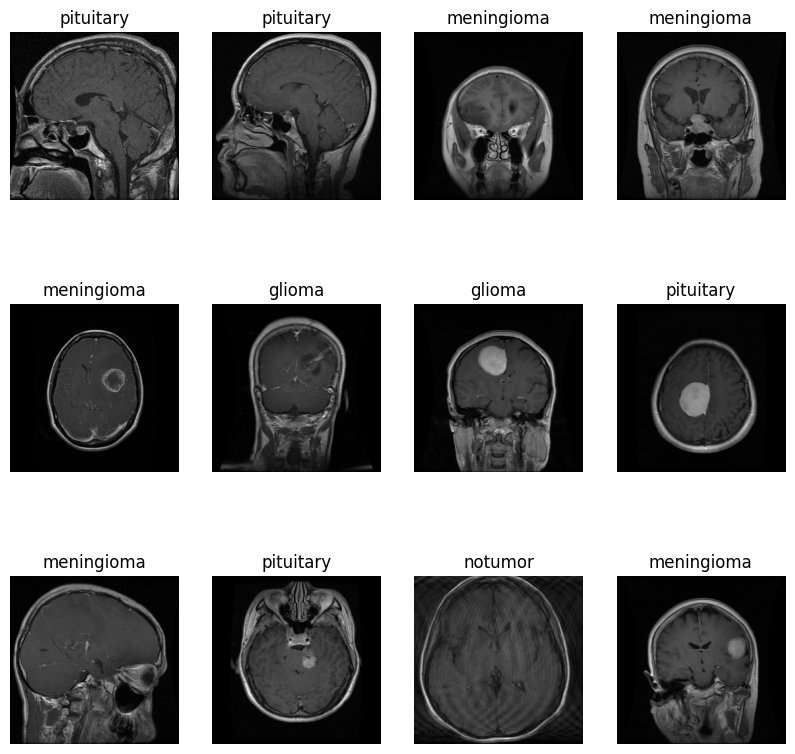

In [105]:
plt.figure(figsize=(10,10))

for image_batch, lables_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4, i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[labels_batch[i]])
        plt.axis('off')
        
plt.show()

# Split Dataset

In [106]:
def get_partition_data(ds, train_split = 0.8, test_split=0.1, val_split=0.1, shuffle=True, shuffle_size=10000):
    assert(train_split + test_split + val_split) == 1
    ds_size = len(dataset)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed =12)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, test_ds, val_ds

In [107]:
train_ds, test_ds, val_ds= get_partition_data(dataset)

In [108]:
print(len(train_ds))
print(len(test_ds))
print(len(val_ds))

143
19
17


# Chach Shuffle And Prefetch Data

In [109]:
trian_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Building Model
**Creating Layers For resizing And Normalization**

In [110]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(0.1 / 256)
])

# Data Augmentation
**Data augmentation needed when we have less data, this boosts the accuracy of out model by augmenting the data**

In [111]:
data_augmentation  = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

# Fit Data Augmentation On Train Dataset

In [112]:
train_ds = train_ds.map(
    lambda x,y: (data_augmentation(x, training=True),y),
).prefetch(buffer_size = tf.data.AUTOTUNE)

# Model Architecture
* We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.

* We are going to use convolutional neural network (CNN) here. CNN is popular for image classification tasks. Watch below video to understand fundamentals of CNN

In [113]:
# adding early stoping to avoid overfitting
from tensorflow.keras.callbacks import EarlyStopping
callback = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [114]:
from tensorflow.keras import models, layers

def build_model(hp):
    units = hp.Int('units', min_value=8, max_value=128, step=8)
    model = models.Sequential([
        resize_and_rescale,
        layers.Conv2D(filters=units, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(filters=units, kernel_size=(3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(filters=units, kernel_size=(3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(filters=units, kernel_size=(3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(units=units, activation='relu'),
        layers.Dense(units=units, activation='relu'),
        layers.Dropout(0.5),
        layers.BatchNormalization(),
        layers.Dense(n_classes, activation='sigmoid')
    ])

    model2.compile(optimizer='adam',
                   loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                   metrics=['accuracy']
                   )

    return model


In [115]:
tuner = kt.RandomSearch(build_opmodel,
                       objective='val_accuracy',
                       max_trials=5,
                       directory='mydr',
                       project_name='tune')

In [116]:
tuner.search(train_ds,epochs=5,validation_data=val_ds)

Trial 4 Complete [00h 03m 44s]
val_accuracy: 0.7536764740943909

Best val_accuracy So Far: 0.8253676295280457
Total elapsed time: 00h 15m 11s


In [117]:
model = tuner.get_best_models(num_models=1)[0]

In [118]:
history = model.fit(train_ds,batch_size=BATCH_SIZE,epochs=30,callbacks=callback,initial_epoch=5,validation_data=val_ds)

Epoch 6/30
143/143 [==============================] - 48s 277ms/step - loss: 0.5693 - accuracy: 0.7825 - val_loss: 0.5426 - val_accuracy: 0.7941
Epoch 7/30
143/143 [==============================] - 45s 273ms/step - loss: 0.5583 - accuracy: 0.7930 - val_loss: 0.4439 - val_accuracy: 0.8401
Epoch 8/30
143/143 [==============================] - 45s 277ms/step - loss: 0.5017 - accuracy: 0.8154 - val_loss: 0.4113 - val_accuracy: 0.8585
Epoch 9/30
143/143 [==============================] - 44s 275ms/step - loss: 0.4799 - accuracy: 0.8252 - val_loss: 0.4720 - val_accuracy: 0.8162
Epoch 10/30
143/143 [==============================] - 45s 274ms/step - loss: 0.4696 - accuracy: 0.8265 - val_loss: 0.3990 - val_accuracy: 0.8676
Epoch 11/30
143/143 [==============================] - 44s 273ms/step - loss: 0.4033 - accuracy: 0.8561 - val_loss: 0.3579 - val_accuracy: 0.8603
Epoch 12/30
143/143 [==============================] - 45s 275ms/step - loss: 0.3789 - accuracy: 0.8612 - val_loss: 0.3086 - val

In [122]:
model.evaluate(test_ds)

19/19 [==============================] - 1s 26ms/step - loss: 0.1126 - accuracy: 0.9688


[0.11257652193307877, 0.96875]

In [120]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation loss')

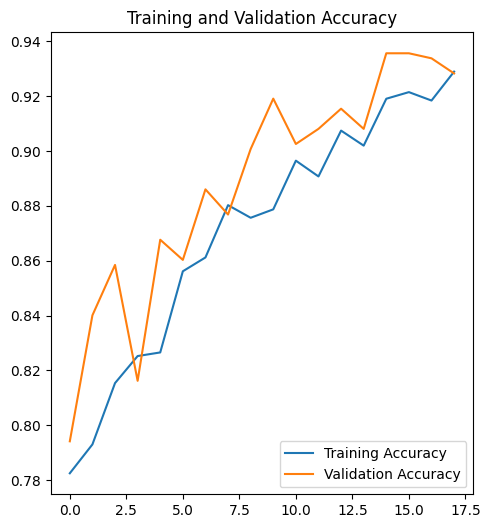

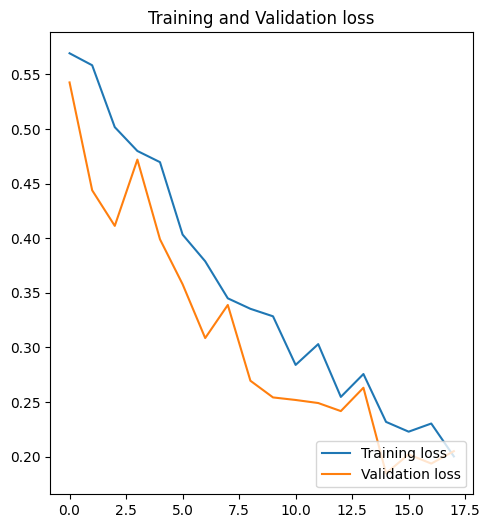

In [121]:
Epochs = len(acc)
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(range(Epochs),acc, label='Training Accuracy')
plt.plot(range(Epochs),val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(range(Epochs),loss, label='Training loss')
plt.plot(range(Epochs),val_loss, label='Validation loss')
plt.legend(loc='lower right')
plt.title('Training and Validation loss')


# Save Model

In [124]:
import os

# List comprehension to filter out non-integer entries
model_versions = [int(i) for i in os.listdir("/kaggle/working/") if i.isdigit()]

# Get the maximum version or default to 0 if the list is empty
model_version = max(model_versions, default=0) + 1

model.save(f"/kaggle/working/{model_version}")


In [125]:
import shutil
# from google.colab import files

# Specify the folder path on Kaggle
folder_path_on_kaggle = "/kaggle/working/1"

# Specify the local destination path for the zip file
local_zip_destination = "downloaded_folder.zip"

# Create a zip file of the folder
shutil.make_archive(local_zip_destination[:-4], 'zip', folder_path_on_kaggle)

'/kaggle/working/downloaded_folder.zip'

# function for test images

In [126]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence


1/1 [==============================] - 0s 19ms/step


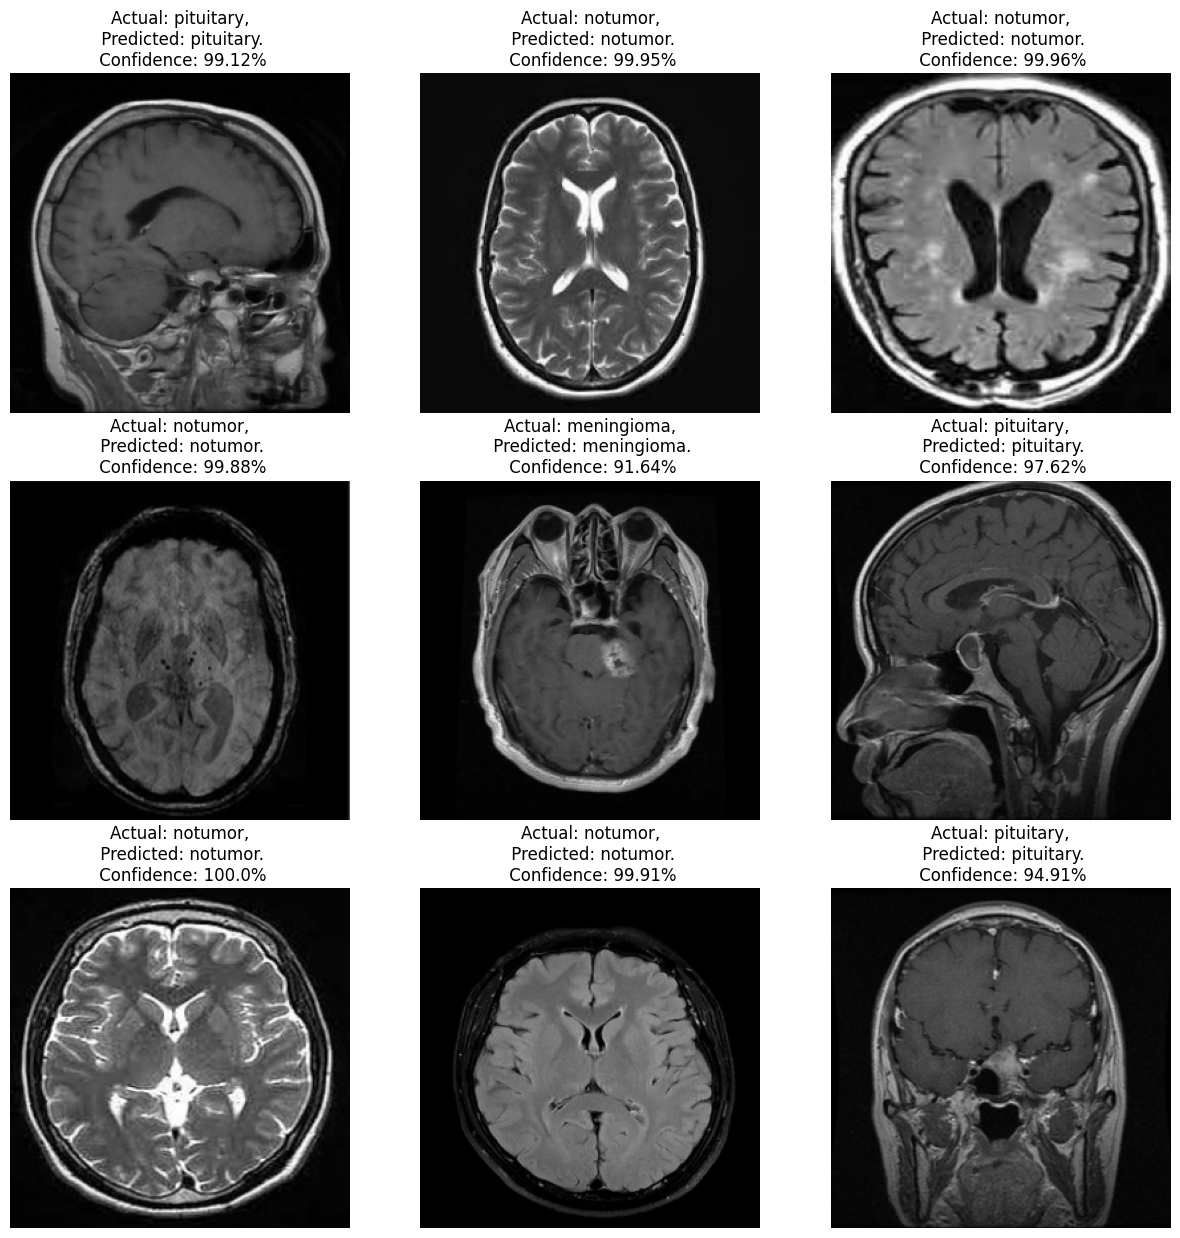

In [127]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")
